In [14]:
import numpy as np
from pathlib import Path
from argparse import ArgumentParser
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import preprocess_input as preprocess_input_vgg
from tensorflow.keras.applications.resnet import preprocess_input as preprocess_input_resnet
from sklearn.metrics import classification_report
from os import listdir


In [15]:
model_name = 'cnn6'
model_path = '/home/jtrell2/data/clef/artifacts/batch_c4b5_all_20_20200120_230313'
test_path = '/home/jtrell2/data/clef/ds1_imageclef_2016_microscopy/test'

BATCH_SIZE = 32

In [16]:
path = Path(model_path) / 'last.hdf5'
test_path = Path(test_path)
model = load_model(path)

In [17]:
total_images  = 0
folders = [f for f in listdir(test_path) if (test_path / f).is_dir()]    
for f in folders:
    total_images += len(listdir(test_path / f))
print('Found %d images ' % total_images)

Found 873 images 


In [22]:
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input_resnet)
target_size = (224, 224)

In [52]:
test_generator = test_datagen.flow_from_directory(
        test_path,
        target_size=target_size,
        class_mode='categorical',
        batch_size=BATCH_SIZE,
        shuffle=False)

Found 873 images belonging to 4 classes.


In [53]:
count = 0
X, Y = [], []
filenames = []

start = 0
while count < total_images:
    batch = test_generator.next()
    
    local_batch_size = batch[0].shape[0]
    end = start + local_batch_size
    
    for image in batch[0]:
        X.append(image)
    for label in batch[1]:
        Y.append(label)
    filenames += [test_generator.filenames[x] for x in test_generator.index_array[start: end]]
    start = end
    
    count += batch[1].shape[0]
X = np.array(X)
Y = np.array(Y)

In [55]:
filenames

['DMEL/1471-2121-11-29-4-3.jpg',
 'DMEL/1471-2121-11-29-4-4.jpg',
 'DMEL/1471-2121-11-29-4-5.jpg',
 'DMEL/1471-2121-11-29-4-7.jpg',
 'DMEL/1471-2121-11-29-4-8.jpg',
 'DMEL/1471-2121-11-79-1-2.jpg',
 'DMEL/1471-2121-11-79-1-3.jpg',
 'DMEL/1471-2121-11-96-5-3.jpg',
 'DMEL/1471-2121-12-32-1-2.jpg',
 'DMEL/1471-213X-1-12-1-6.jpg',
 'DMEL/1471-213X-10-88-7-1.jpg',
 'DMEL/1471-213X-10-88-7-2.jpg',
 'DMEL/1471-213X-10-88-7-3.jpg',
 'DMEL/1471-213X-10-88-7-4.jpg',
 'DMEL/1471-213X-10-88-7-6.jpg',
 'DMEL/1471-213X-10-88-7-7.jpg',
 'DMEL/1471-213X-10-88-7-8.jpg',
 'DMEL/1471-213X-6-54-12-1.jpg',
 'DMEL/1471-213X-6-54-12-3.jpg',
 'DMEL/1471-213X-6-8-2-2.jpg',
 'DMEL/1471-213X-6-8-2-3.jpg',
 'DMEL/1471-213X-6-8-2-5.jpg',
 'DMEL/1471-213X-6-8-2-6.jpg',
 'DMEL/1471-213X-6-8-2-8.jpg',
 'DMEL/1471-213X-7-28-2-1.jpg',
 'DMEL/1471-213X-7-28-2-2.jpg',
 'DMEL/1471-213X-7-28-2-3.jpg',
 'DMEL/1471-213X-7-28-2-4.jpg',
 'DMEL/1471-213X-7-28-2-5.jpg',
 'DMEL/1471-213X-7-28-2-6.jpg',
 'DMEL/1471-213X-7-28-2-7.j

In [25]:
results = model.evaluate(X, Y, batch_size=32)

873/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

In [27]:
from tensorflow.keras.utils import to_categorical
y_probs = model.predict(X)    
y_pred = np.argmax(y_probs, axis=1)
y_pred_categorical = to_categorical(y_pred)

print(classification_report(Y, y_pred_categorical, digits=4, target_names=test_generator.class_indices))

              precision    recall  f1-score   support

        DMEL     0.6098    0.5682    0.5882        88
        DMFL     0.9401    0.9401    0.9401       284
        DMLI     0.9103    0.9778    0.9429       405
        DMTR     0.7778    0.5833    0.6667        96

   micro avg     0.8809    0.8809    0.8809       873
   macro avg     0.8095    0.7674    0.7845       873
weighted avg     0.8752    0.8809    0.8759       873
 samples avg     0.8809    0.8809    0.8809       873



In [293]:
import matplotlib.pyplot as plt
%matplotlib inline
CLASSES = np.array(['', 'DMEL', 'DMFL', 'DMLI', 'DMTR'])
from sklearn.metrics import confusion_matrix, f1_score
from sklearn.utils.multiclass import unique_labels
import matplotlib.ticker as plticker
from matplotlib.ticker import MaxNLocator

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues,
                          output=''):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    #classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    classes = list(classes)

    plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.colorbar()
    
    ax = plt.gca()
    loc = plticker.MultipleLocator(base=1.0)
    ax.xaxis.set_major_locator(loc)
    ax.yaxis.set_major_locator(loc)
    
    #tick_marks = np.arange(len(classes))    
    #ax.set_xticklabels(classes)
    #ax.set_yticklabels(classes)
    #plt.xticks(tick_marks)
    #plt.yticks(tick_marks)
#     fig, ax = plt.subplots(figsize=(5, 5))
#     im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
#     ax.figure.colorbar(im, ax=ax)
    
#     ax.yaxis.set_major_locator(MaxNLocator(integer=True))
#     ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    
    
#     # We want to show all ticks...
    ax.set(#xticks=np.arange(cm.shape[1]),
           #yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           #title=title,
           ylabel='True label',
           xlabel='Predicted label')

    #ax.set_yticklabels(classes)
    # Rotate the tick labels and set their alignment.
#     plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
#              rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    #fig.savefig(str(output / 'confusion.png'))
    return ax

Confusion matrix, without normalization
[[ 50  11  17  10]
 [ 10 267   5   2]
 [  2   3 396   4]
 [ 20   3  17  56]]


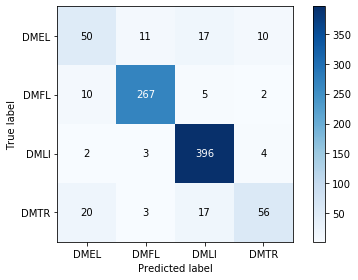

In [294]:
plot_confusion_matrix(ys, preds, classes=CLASSES, output='./')

In [34]:
Y

array([[1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       ...,
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.]], dtype=float32)

In [122]:
def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):
    """Prints a confusion matrix, as returned by sklearn.metrics.confusion_matrix, as a heatmap.
    
    Arguments
    ---------
    confusion_matrix: numpy.ndarray
        The numpy.ndarray object returned from a call to sklearn.metrics.confusion_matrix. 
        Similarly constructed ndarrays can also be used.
    class_names: list
        An ordered list of class names, in the order they index the given confusion matrix.
    figsize: tuple
        A 2-long tuple, the first value determining the horizontal size of the ouputted figure,
        the second determining the vertical size. Defaults to (10,7).
    fontsize: int
        Font size for axes labels. Defaults to 14.
        
    Returns
    -------
    matplotlib.figure.Figure
        The resulting confusion matrix figure
    """
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    return fig

Confusion matrix, without normalization


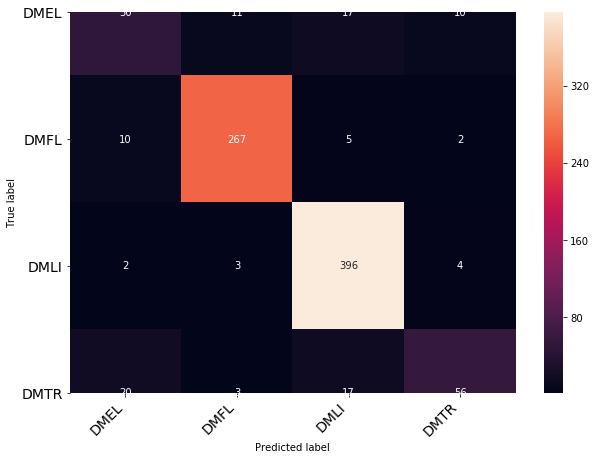

<Figure size 432x288 with 0 Axes>

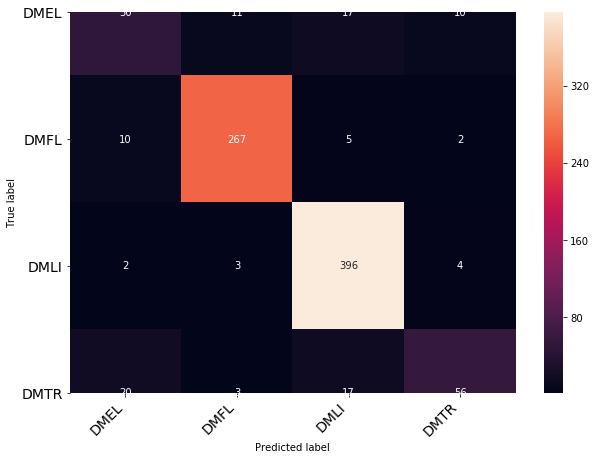

In [125]:
import pandas as pd
import seaborn as sns
# Compute confusion matrix
cm = confusion_matrix(ys, preds)
classes = CLASSES[unique_labels(ys, preds)]
normalize = False
if normalize:
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    print("Normalized confusion matrix")
else:
    print('Confusion matrix, without normalization')
    
plt.tight_layout() 
print_confusion_matrix(cm, CLASSES)

In [112]:
preds

[0,
 1,
 1,
 0,
 0,
 0,
 2,
 3,
 2,
 2,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 3,
 3,
 3,
 3,
 3,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 2,
 2,
 2,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 2,
 2,
 2,
 3,
 3,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 2,
 0,
 2,
 0,
 0,
 0,
 0,
 2,
 2,
 2,
 2,
 2,
 0,
 1,
 2,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 3,
 3,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 3,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 2,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,


In [39]:
preds = [np.argmax(x) for x in y_pred_categorical]

In [40]:
ys = [np.argmax(x) for x in Y]

In [77]:
mistakes = []
mis_preds = []
mis_trues = []
for idx_pred, pred in enumerate(preds):
    if pred != ys[idx_pred]:
        mistakes.append(filenames[idx_pred])
        mis_preds.append(pred)
        mis_trues.append(ys[idx_pred])

In [59]:
len(mistakes)

104

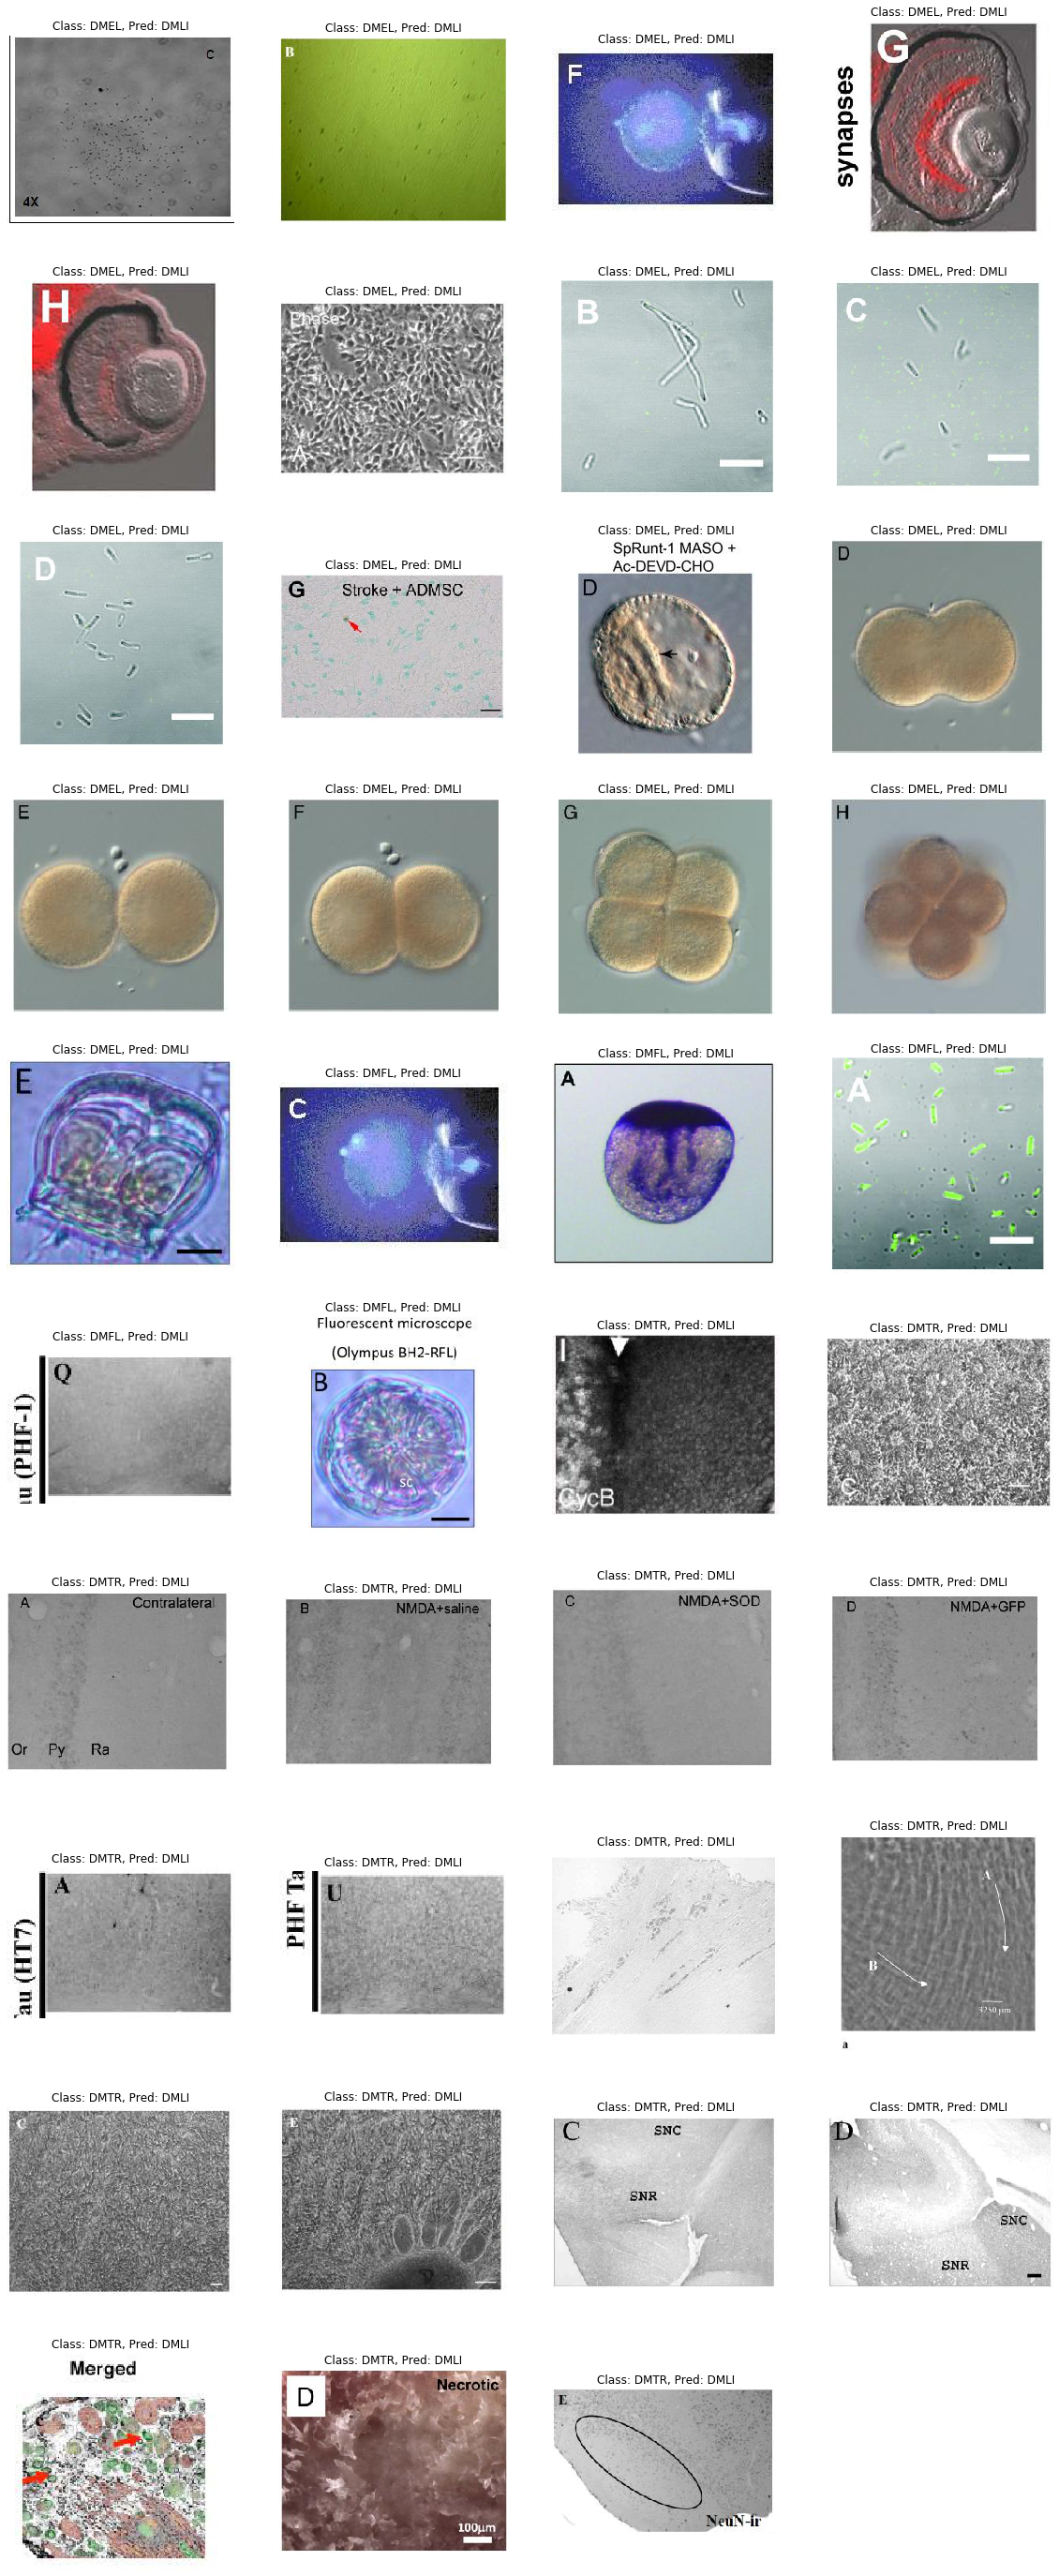

In [107]:
from os import listdir
from PIL import Image
imgs_path = Path('/home/jtrell2/data/clef/ds1_imageclef_2016_microscopy/test')

paths = [imgs_path / x for x in mistakes]
imgs = [Image.open(x) for x in paths]

classes = ['DMEL', 'DMFL', 'DMLI', 'DMTR']
num_class = [x for x in mis_preds if classes[x] == 'DMLI']
rows = len(num_class)//4 + 1

fig = plt.figure(figsize=(20,50))

c = 0
for i in range(len(mistakes)):    
    orig_class = classes[int(mis_trues[i])]
    pred_class = classes[int(mis_preds[i])]
    if pred_class == 'DMLI':        
        ax = fig.add_subplot(rows, 4, c+1)
        ax.axis('off')
        ax.set_title('Class: %s, Pred: %s' % (orig_class, pred_class))
        plt.imshow(imgs[i])
        c += 1

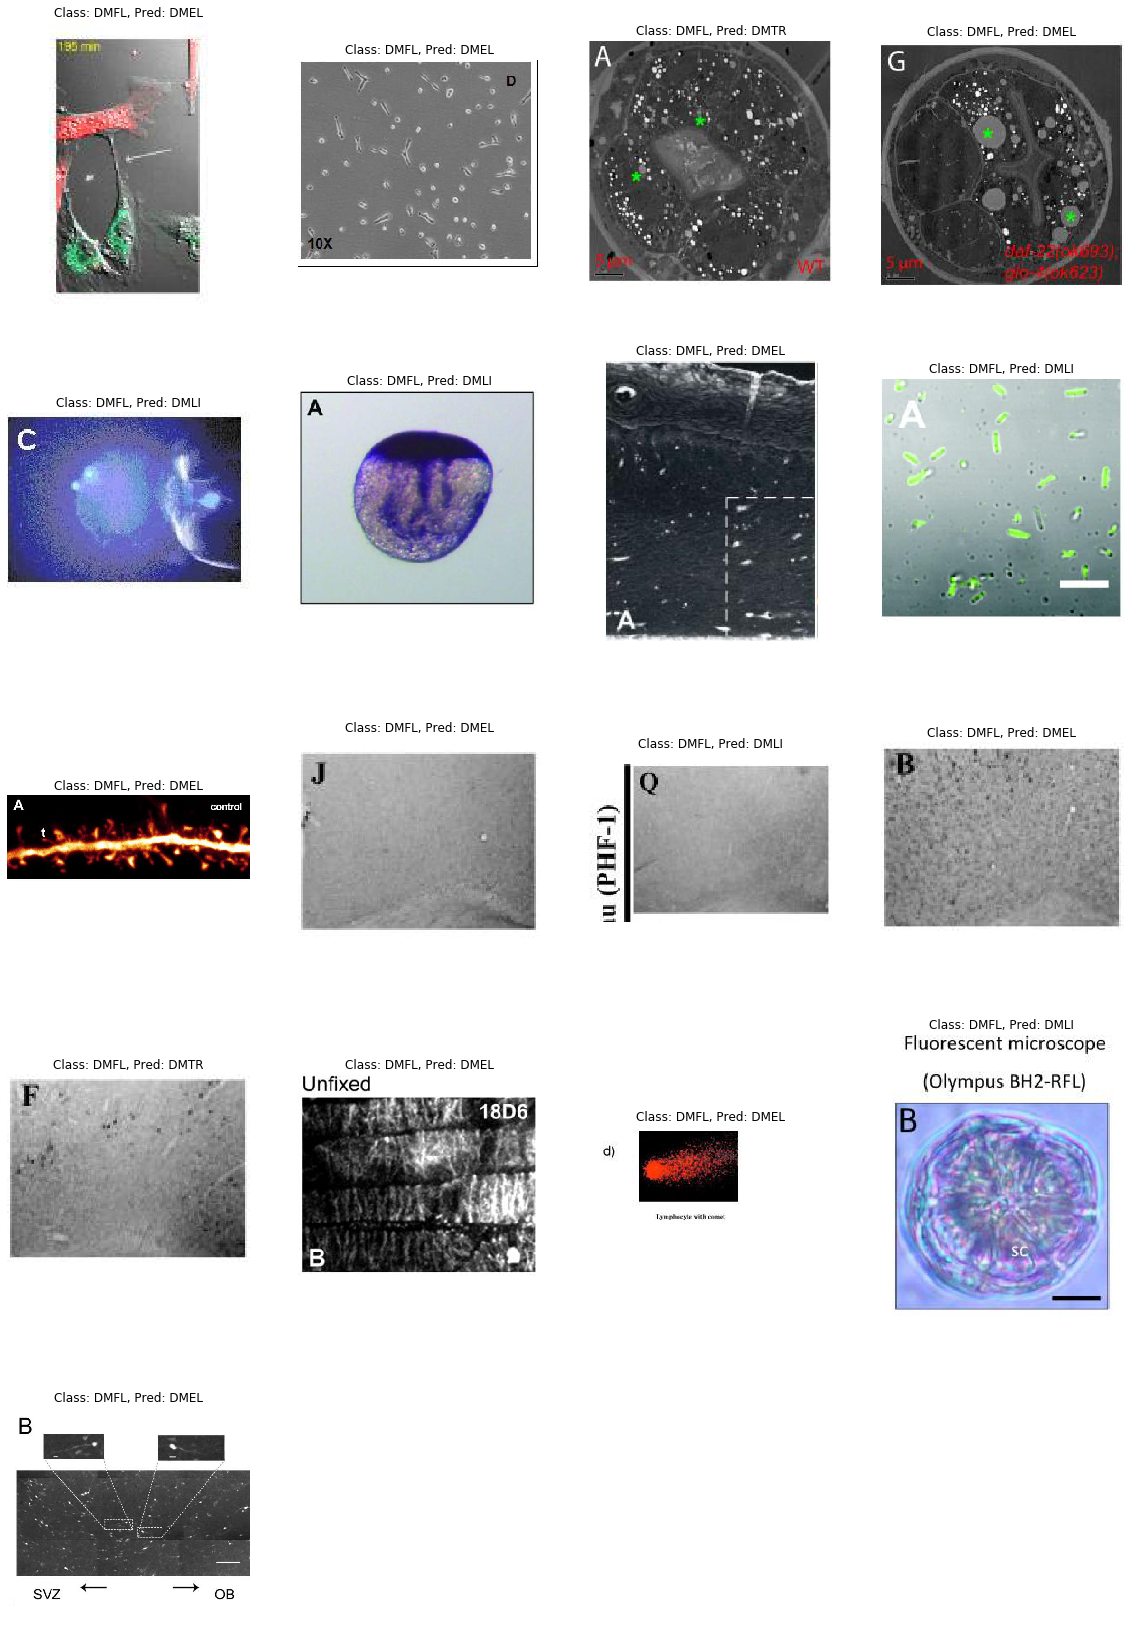

In [105]:
from os import listdir
from PIL import Image
imgs_path = Path('/home/jtrell2/data/clef/ds1_imageclef_2016_microscopy/test')

paths = [imgs_path / x for x in mistakes]
imgs = [Image.open(x) for x in paths]

classes = ['DMEL', 'DMFL', 'DMLI', 'DMTR']
num_class = [x for x in mis_trues if classes[x] == 'DMFL']
rows = len(num_class)//4 + 1

fig = plt.figure(figsize=(20,30))

c = 0
for i in range(len(mistakes)):    
    orig_class = classes[int(mis_trues[i])]
    pred_class = classes[int(mis_preds[i])]
    if orig_class == 'DMFL':        
        ax = fig.add_subplot(rows, 4, c+1)
        ax.axis('off')
        ax.set_title('Class: %s, Pred: %s' % (orig_class, pred_class))
        plt.imshow(imgs[i])
        c += 1